# E-commerce — Выявление профилей потребления

## Материалы:
* [Презентация](https://docs.google.com/presentation/d/1u6BVBcCylTOCx4NNpXACgtzV1U5LRiEIIMdhxvSyHM0/edit?usp=sharing)

## Описание проекта

Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. 

Вы поможете нашему магазину стать лучше, а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — расчёт метрик и создание гипотез на основе полученных данных.
«Пока все ещё тут» — мы создаём уют!

## Задачи проекта

   - Сегментировать покупателей по профилю потребления
   - Проведите исследовательский анализ данных
   - Сегментируйте покупателей на основе истории их покупок

## Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока
все ещё тут».

Колонки в `/datasets/ecom_dataset_upd.csv`:
   - `date` — дата заказа;
   - `customer_id` — идентификатор покупателя;
   - `order_id` — идентификатор заказа;
   - `product` — наименование товара;
   - `quantity` — количество товара в заказе;
   - `price` — цена товара.

## Этапы исследования проекта

   - Загрузка библиотек и чтение данных
   - Предобработка данных
   - Исследовательский анализ данных
   - Сегментация покупателей, гипотезы
   - Выводы
   - Презентация


## Загрузка библиотек и чтение данных

In [1]:
!pip install nltk
!pip install pymorphy2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats
import pymorphy2
import urllib
morph = pymorphy2.MorphAnalyzer() #сразу же инициализируем морфанализатор
import re
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_colwidth = 100

In [4]:
try:
    df = pd.read_csv('/datasets/ecomme_dataset_upd.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [5]:
# Посмотрим на первые 5 строк датасета
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [6]:
# Посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В рамках предобработки предполагается выполнить следующие действия:

* Проверить таблицу на наличие полных дубликатов
* Количество 7474 значений во всех столбцах указывает на отсутствие пропусков в данных
* Привести тип в столбце `date` к типу даты из формата целого числа

## Предобработка данных

### Работа с столбцом даты

Как и было отмечено в первичном анализе датасета, столбец `date` необходимо перевести в формат даты.

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [8]:
df['date']

0      2018-10-01 00:00:00
1      2018-10-01 00:00:00
2      2018-10-01 00:00:00
3      2018-10-01 00:00:00
4      2018-10-01 00:00:00
               ...        
7469   2020-01-30 21:00:00
7470   2020-01-30 22:00:00
7471   2020-01-31 02:00:00
7472   2020-01-31 12:00:00
7473   2020-01-31 15:00:00
Name: date, Length: 7474, dtype: datetime64[ns]

Подготовим дополнительные столбцы с датой без времени, с временем, месяцем и днем недели для дальнейшего изучения

In [9]:
df['month'] = df['date'].values.astype('datetime64[M]')

Посмотрим какой временной отрезок охватывает датасет

In [10]:
print('Самая раняя дата:', np.min(df['date']))
print('Самая поздняя дата:', np.max(df['date']))
print('Количество дней в исследуемом периоде:', (np.max(df['date']) - np.min(df['date'])).days)

Самая раняя дата: 2018-10-01 00:00:00
Самая поздняя дата: 2020-01-31 15:00:00
Количество дней в исследуемом периоде: 487


Как мы видим датасет охватывает период с 1 октября 2018 года по 31 января 2020 года, но целиком представлен лишь 2019 год, что мешает корректно сравнивать показатели по годам.

### Проверка на пропуски

Проверим отсутствие пропусков в данных

In [11]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
month          0
dtype: int64

Как и подметили в первичном осмотре данных пропуски в столбцах отсутствуют.

### Проверка на дубликаты

Проверим отсутствие дубликатов в данных

In [12]:
print('Количество полных дубликатов в данных:', sum(df.duplicated()))

Количество полных дубликатов в данных: 0


Приведем столбец `product` к нижнему регистру для поиска неявных дубликатов

In [13]:
df['product'] = df['product'].replace({'ё': 'е', 'Ё': 'Е',' {2,}': ' '}, regex=True)\
                             .str.strip()

Как видим, полных дубликатов в таблице нет.

Посчитаем количество клиентов и заказов в оригинальном датасете.

In [14]:
print('Количество клиентов:',df['customer_id'].nunique())
print('Количество заказов:',df['order_id'].nunique())

Количество клиентов: 2451
Количество заказов: 3521


В датасете мы имеем 2451 уникальных клиентов, которые совершили 3521 заказов на общую сумму 5 357 944 рублей.

In [15]:
df[df.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price'], \
                 keep=False)]

,date,customer_id,order_id,product,quantity,price,month
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Мини-сковорода Marmiton ""Сердце"" с антипригарным покрытием 12 см, LG17085",1,239.0,2018-10-01
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Сковорода алюминиевая с антипригарным покрытием MARBLE ALPENKOK d = 26 см AK-0039A/26N,1,824.0,2018-10-01
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Стеклянная крышка для сковороды ALPENKOK 26 см AK-26GL,1,262.0,2018-10-01
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Сушилка для белья напольная Colombo Star 18, 3679",1,1049.0,2018-10-01
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018-10-01
...,...,...,...,...,...,...,...
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-01
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,2019-10-01
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-01
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-01


То есть клиент в одном заказе покупает разные позиции и все они проходят под одним id заказа (тут все логично), но мы видим, что есть такие заказы (к примеру, 73136), где покупается один и тот же товар одним и тем же клиентом, в одном и том же количестве, по одной и той же цене, под одним id заказа, но при этом в разное время. Это похоже на задублированные заказы. Если их оставить, то это может исказить данные нашего исследования. Отфильтруем такие заказы.

Уберем параметр keep=False, только первая запись будет считаться уникальной, а все остальные одинаковые будут считаться дубликатами.

In [16]:
"Процент задублированных заказов: {:.1%}".format(\
    len(df[df.duplicated(subset=['customer_id','order_id', 'product', 'quantity', 'price'])])
                                                 / df.shape[0]
                                                )

'Процент задублированных заказов: 24.9%'

In [17]:
f"Количество строк в датасете с задублированными заказами: {len(df[df.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price'])])}"

'Количество строк в датасете с задублированными заказами: 1864'

Будем считать актуальным тот заказ, который был совершен самым последним по дате.

Удаляем из нашего датасета строки с одинаковыми customer_id, order_id, product, 'quantity', 'price' и оставляем только самую последнюю строку-дубли

In [18]:
df = df.sort_values(by='date')\
.drop_duplicates(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price'],\
                 keep='last')

Проверим ранее задублированный заказ 73136.

In [19]:
df.query('order_id==73136')

,date,customer_id,order_id,product,quantity,price,month
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-01


Все в порядке: остался только самый поздний по дате заказ пластмассового таза со стиральной доской.

Теперь еще посмотрим на строки, где одинаковые айдишники заказа и купленные товары.

In [20]:
df[df.duplicated(subset=['order_id', 'product', 'price', 'quantity'], keep=False)]

,date,customer_id,order_id,product,quantity,price,month
512,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0,2018-10-01
538,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0,2018-10-01
1154,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.0,2018-12-01
1160,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.0,2018-12-01
1196,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,69345,Сушилка для белья Attribute ПРИМА 18 м синяя ADP618,1,974.0,2018-12-01
...,...,...,...,...,...,...,...
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-01
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-01
6576,2019-10-10 22:00:00,31a39955-8a93-42f3-8839-04a9693632a7,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0,2019-10-01
6601,2019-10-13 15:00:00,b1dbc7c4-3c84-40a7-80c9-46e2f79d24ad,72950,Кастрюля эмалированная Стэма С-1624 12 л цилиндрическая без рисунка 1506037,1,974.0,2019-10-01


In [21]:
f"Процент одинаковых заказов c одинаковым айди у разных пользователей {len(df[df.duplicated(subset=['order_id', 'product', 'quantity', 'price'])])/df.shape[0]:.1%}"

'Процент одинаковых заказов c одинаковым айди у разных пользователей 0.6%'

Один и тот же заказ, сделанный разными пользователями. Это, похоже, на ошибку. Удалим их все из нашего датасета.

In [22]:
df = df.drop_duplicates(subset=['order_id', 'product', 'quantity', 'price'], keep=False)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5547 entries, 0 to 7473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5547 non-null   datetime64[ns]
 1   customer_id  5547 non-null   object        
 2   order_id     5547 non-null   int64         
 3   product      5547 non-null   object        
 4   quantity     5547 non-null   int64         
 5   price        5547 non-null   float64       
 6   month        5547 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 346.7+ KB


### Работа с данными в датасете

Добавим столбец с выручкой 

In [24]:
df['total_price'] = df['quantity'] * df['price']

Посмотрим общую выручку по всему датасету

In [25]:
print('Общая выручка равна:', round(df['total_price'].sum(), 2), 'рублей')

Общая выручка равна: 4602612.42 рублей


In [26]:
print('Количество клиентов:',df['customer_id'].nunique())
print('Количество заказов:',df['order_id'].nunique())

Количество клиентов: 2415
Количество заказов: 3494


### Выводы по предобработке данных

По итогам предобработки данных следующие выводы:
- 2415 уникальных клиентов
- 3494 заказов
- Пропуски и дубликаты отсутствуют
- Период составляет 487 дней (менее 1.5 года) c 2018 по 2020 годы
- Поле даты было приведено к формату даты

## Исследовательский анализ данных

### Определение товарных категорий

In [27]:
""" Функция для предобработки и токенизации текста:

Функция очищает строку от знаков препинания, токенизирует (разбивает на слова) с помощью токенизатора из библиотеки nltk,
убирает стоп-слова, слова, проверяет, есть ли в слове смесь букв из кириллицы и латиницы, если да - заменяет латинские буквы на кириллические
и оставляет в списке только слова с буквами русского алфавита и дефисом, где не меньше 3 символа. 

Аргументы:
    text - строка 
    
Вывод:
    good_tokens - список слов 
"""
def preprocessing(text):
    # удаляем пунктуацию
    text = re.sub(r'[!\"#$%&\'()*+,./:;<=>?@^_`{|}~]|( -)|(\[)|(\])', '', text)
    tokens =  word_tokenize(text)
    good_tokens = []
    for token in tokens:
        # убираем стоп-слова и оставляем только слова, 
        #в которых кириллические буквы и больше 3
        if token not in stopwords.words('russian') and re.fullmatch(r'[ABCEHKMOPTXacpmeoxy-]+[а-яА-Я]{2,}', token) is not None:
            #заменяем латинские буквы на кириллические (Tepмокружка)
            token = token.translate(str.maketrans('ABCEHKMOPTXacpmeoxy','АВСЕНКМОРТХасрмеоху'))
            good_tokens.append(token)
        elif token not in stopwords.words('russian') and re.fullmatch(r'[а-яА-Я-]{3,}', token) is not None:
            good_tokens.append(token)
    return good_tokens

In [28]:
"""
Функция для лемматизации текста:

Функция берет на вход строку, предобрабатывает ее с помощью встроенной функции preprocessing и возвращает только имена существительные 
в начальной форме, склеенные в строку через пробел. Для лемматизации и морфологического анализа используется библиотека pymorphy.

Аргументы:
    text - строка с текстом 
    
Вывод:
    key_lemmas - строка со словами в начальной форме. 

"""
def lemmatize_text(text):
    lemmas = []
    tokens = preprocessing(text)
    #print(tokens)
    for token in tokens:
        morph_analized = morph.parse(token) # морф анализ
        #print(morph_analized[0].word)
        if morph_analized[0].word == 'мята': #затычка для "мяты" (у pymorphy выигрывает разбор через прилагательное мятый)
            lemmas.append('мята')
        elif morph_analized[0].word == 'гвоздика': #затычка для "гвоздики" (у pymorphy выигрывает разбор через существительное "гвоздик")
            lemmas.append('гвоздика')
        elif morph_analized[0].word == 'петля': # иначе выигрывает анализ через "петлить"
            lemmas.append('петля')
        elif morph_analized[0].word == 'сверел':
            lemmas.append('сверло')
        elif morph_analized[0].word == 'космея':
            lemmas.append('космея')
        elif morph_analized[0].word == 'совок':
             lemmas.append('совок')
        else:
            lemmas.append(morph_analized[0].normal_form) #извлекаем лемму-начальную форму слова
    #склеиваем список в строку, разделяя леммы пробелом
    key_lemmas = ' '.join(lemmas).strip()        
    return key_lemmas

In [29]:
%time
df['product_lemmas'] = df['product'].apply(lemmatize_text)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [30]:
df.head()

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,комнатный растение горшок алый вера
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,194.0,комнатный растение горшок кофе арабика
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,радермахер
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,хризолидокарпус лутесценс
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,циперус зумул


In [31]:
df['product_lemmas'].value_counts().sort_values(ascending=False)

пеларгония розебудный укоренить черенок             234
сумка-тележка колёсный синий                         57
пеларгония зональный диам сиреневый полумахровый     53
сушилка бельё потолочный лиана                       51
сумка-тележка хозяйственный синий                    49
                                                   ... 
фиттония скелетон                                     1
сумка-тележка хозяйственный оранжевый                 1
набор бокал император франция                         1
земляника барон солемахер                             1
пружина дверной оцинковать крепление                  1
Name: product_lemmas, Length: 1986, dtype: int64

Отдельно создадим список с ключевыми словами - возьмем только первые в названии, если это не набор.

In [32]:
key_wrds = []
for elem in df['product_lemmas'].unique().tolist():
    if elem.split()[0] == 'набор': # если набор, нужно смотреть его состав
        if elem.split()[1] in key_wrds:
            
            continue
        else:
            key_wrds.append(elem.split()[1])
    else:
        if elem.split()[0] in key_wrds:
            continue
        else:
            key_wrds.append(elem.split()[0])
print('Длина списка с ключевыми словами (существительные и прилагательные):', len(key_wrds))

Длина списка с ключевыми словами (существительные и прилагательные): 449


In [33]:
key_wrds[:10]

['комнатный',
 'радермахер',
 'хризолидокарпус',
 'циперус',
 'шеффлера',
 'юкка',
 'таз',
 'настенный',
 'чехол',
 'вешалка']

Попробуем убрать прилагательные из этого списка и отсортируем в алфавитном порядке.

In [34]:
for elem in key_wrds:
    #убираем прилагательные
    if elem.endswith(('ый', 'ий')):
        key_wrds.remove(elem)
print('Длина списка с ключевыми словами (только существительными):', len(key_wrds))
sorted(key_wrds)[:10]

Длина списка с ключевыми словами (только существительными): 405


['агератум',
 'адиантум',
 'азалия',
 'аквилегия',
 'алиссума',
 'алоэ',
 'альбук',
 'амариллис',
 'анемон',
 'антижир']

In [35]:
sorted(df['product_lemmas'].unique().tolist())[:10]

['автоматический щётка мытьё окно ручка',
 'агератум рассада однолетний цвет кассета',
 'адиантум лиза',
 'азалия индик биколор',
 'азалия индик розовый',
 'азалия индик фиолетовый',
 'аквилегия махровый тауэр смесь окраска объём',
 'аквилегия обыкновенный барлоу микс объём',
 'алиссума лобулярия снежный одежда',
 'алиссума рассада однолетний цвет кассета']

На основе всех этих списков попробуем вручную создать словарь с категориями товаров.

Тестовая ячейка для проверки, работы с текстом

In [36]:
df[df['product_lemmas'].str.contains(r'чехол хлопок')].head()

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas
12,2018-10-01 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68485,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42,1,187.0,2018-10-01,187.0,чехол хлопок доска
1087,2018-12-03 12:00:00,4c012ce2-d9fa-402b-b07b-9a9a5e405c44,69184,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42,1,187.0,2018-12-01,187.0,чехол хлопок доска
2977,2019-04-20 14:00:00,1a44dab1-2a18-4c95-83a1-b64e4e883f5f,71211,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42,1,187.0,2019-04-01,187.0,чехол хлопок доска
3189,2019-04-26 14:00:00,8f00cdbf-0de2-4bad-a84f-e437ba684f30,71294,"Чехол Eurogold Clean Premium хлопок, поролон, для досок 110х30-114x34 см C34F3",1,217.0,2019-04-01,217.0,чехол хлопок поролон доска
6824,2019-11-10 22:00:00,2a6ab3d5-85c0-47af-81dc-ec0da34d903c,111477,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42,1,187.0,2019-11-01,187.0,чехол хлопок доска


### Словарь категорий товаров

Создадим словарь словарных категорий на основе тех списков слов, что мы выделили выше.

Ключ словаря - товарная категория. Значения словаря - список лемм, характерных для этой категории.

In [37]:
product_cats = {'plants_seeds': [
    'ампельный',
    'вечноцветущий',
    'зональный',
    'комнатный',
    'лекарственный',
    'многолетний',
    'низкорослый',
    'однолетний',
    'позднеспелый',
    'почвопокровный',
    'плющелистный',
    'раннеспелый',
    'скороспелый',
    'среднеспелый',
    'розебудный',
    'микс объём',
    'растение',
    'черенок',
    'кассета',
    'кустовой',
    'рассада',
    'горшок',
    'чашелист',
    'чайногибридный',
    'одноголовый',
    'очиток',
    'подвесной кашпо',
    'азалия',
    'агератум',
    'адиантум',
    'аквилегия',
    'аллисума',
    'алоэ вера',
    'альбук',
    'амариллис',
    'анемон',
    'алиссума',
    'арбуз волгоградец',
    'арбуз огонёк',
    'арбуз сибирский',
    'арбуз холодок',
    'арбуз шуга бейбить',
    'антуриум',
    'аптения',
    'артемизия',
    'аспарагус',
    'афеляндр',
    'бадан',
    'базилик',
    'баклажан самурай',
    'бальзамин',
    'бакоп',
    'барвинок',
    'бархатцы',
    'бегония',
    'буддлей',
    'бузульник',
    'валериан',
    'вербейник',
    'вербена',
    'вероника',
    'виола',
    'высокорослый',
    'гардения',
    'газаний',
    'гайлардия',
    'гвоздика',
    'георгин',
    'герань', 
    'гербер',
    'гиацинт',
    'гимнокалициум',
    'гиностемма',
    'гипсофил',
    'глоксиния',
    'годеция',
    'горох',
    'гортензия', 
    'девичий виноград',
    'декабрист горшок',
    'дендробиум',
    'драцена',
    'душица',
    'дыня алтайский',
    'дыня дин',
    'дыня золотой',
    'дыня колхозница',
    'дыня медовый',
    'дыня млада',
    'дыня награда',
    'дыня симпатия',
    'ель канадский', 
    'ель сербский',
    'джункус',
    'диффенбахий',
    'замиокулькас',
    'зверобой',
    'земляника',
    'змееголовник',
    'импатиенс',
    'иссоп',
    'кабачок',
    'каланхий',
    'калатея',
    'календула',
    'калибрахоа',
    'калла',
    'каллуна',
    'калоцефалус',
    'камнеломка',
    'кампанула',
    'капсикума',
    'капуста', 
    'кассета',
    'кипарисовик',
    'клён',
    'квадро цвет венга',
    'кипарисовик',
    'клубника альба',
    'клубника мара',
    'клубника хонь',
    'колокольчик',
    'крассула',
    'космея ', # затычка, чтобы не ловить таз "Космея"
    'кореопсис',
    'котовник',
    'кореопсис',
    'кофе ',  # затычка, чтобы не ловить в "кофейный"
    'лобелия',
    'луковица',
    'лаванда',
    'лаватер',
    'лавр',
    'лантан',
    'лапчатка',
    'лен небесный',
    'лобулярия',
    'литопс',
    'мединилла',
    'мята',
    'мирт',
    'мимоза',
    'морковь детский',
    'молодило',
    'муррайя',
    'монард',
    'нолин',
    'незабудка',
    'нефролепис',
    'настурция',
    'нивянник',
    'овсянница',
    'огурец засолочный',
    'осина',
    'пеларгония',
    'петуния',
    'петрушка',
    'пиретрум',
    'портулак',
    'примула',
    'пряный трава',
    'пуансетие',
    'пуансеттие',
    'папоротник',
    'платикодон',
    'пахир',
    'пеперомия',
    'радермахер', 
    'роза мини',
    'роза корда',
    'роза патио',
    'роза мин',
    'роза палас',
    'розмарин',
    'ранункулус',
    'рудбекия',
    'суккулента',
    'сантолина',
    'салат рукол',
    'спатифиллум',
    'соланум',
    'солидаго',
    'скиммия',
    'спатифиллум',
    'смолёвка',
    'сорт ', #затычка чтобы не цеплять "ассортимент"
    'тимьян',
    'томат помидор',
    'тюльпан',
    'томат балконный',
    'хризолидокарпус', 
    'хризантема',
    'чабёр',
    'циперус',
    'цикламен',
    'цинерария',
    'цинния',
    'цитрофортунелла',
    'укроп',
    'шеффлера',
    'фиалка',
    'флокс',
    'фиттония',
    'фикус',
    'фаленопсис',
    'фатсия',
    'физостегия',
    'хамедорей',
    'хлорофитум',
    'хризантема',
    'эхеверие',
    'эхинокактус',
    'эвкалипт',
    'эшшольция',
    'эпипремнум',
    'эпипремнум',
    'энотера',
    'эхинокактус',
    'юкка',
    'ясколка',
    'чабёр'],
             
'kitchen': [
    'вилка',
    'венчик',
    'выпечка',
    'ёмкость',
    'зажигалка',
    'нож',
    'банк',
    'блюдо',
    'блюдце',
    'бульонница',
    'бокал',
    'доска разделочный',
    'измельчитель',
    'картофелемялка',
    'кастрюля',
    'кипятильник',
    'кисточка',
    'ковш',
    'коврик сушка',
    'кувшин',
    'кружка',
    'кухонный',
    'крышка',
    'кондитерский',
    'кекс',
    'лопатка',
    'лоток',
    'ложка столовая',
    'мантоварка',
    'маслёнка',
    'миксер',
    'миска',
    'ножеточка',
    'набор столовый',
    'овощерезка',
    'овощечистка',
    'овощеварка',
    'орехоколка',
    'отделитель',
    'противень',
    'пресс чеснок',
    'пикник',
    'половник',
    'посуда',
    'подставка',
    'просеиватель',
    'разделочный доска',
    'рассекатель',
    'рыбочистка',
    'сковорода',
    'cтоловый',
    'соковыжималка',
    'стакан',
    'салатник',
    'салфетка',
    'салфетница',
    'сахарница',
    'сито',
    'скалка',
    'столовая',
    'соковарка',
    'сотейник',
    'тортница',
    'тарелка',
    'толкушка',
    'тёрка',
    'термос',
    'фужер',
    'штопор',
    'экран',
    'чайный',
    'чайник',
    'хлебница',
    'яйцо'

],
'bathroom_wc': [
    'ванна',
    'ванная',
    'вантуз',
    'дозатор',
    'держатель туалетный',
    'ёрш',
    'карниз',
    'подголовник',
    'штора'
],

'cleaning_washing': [
    'антижир',
    'антинакипин',
    'бак',
    'биопорошок',
    'ведро',
    'веник',
    'гель',
    'губка',
    'гладильный',
    'зубной паста',
    'кондиционер',
    'концентрат',
    'микрофибра',
    'мыло',
    'мытьё',
    'мойка',
    'ополаскиватель', 
    'отбеливатель',
    'отжим',
    'паста зубной',
    'подкладка',
    'пена',
    'перчатка',
    'прищепка',
    'ролик',
    'соль',
    'смётка',
    'совок',
    'скребок',
    'сетка глажение',
    'сушилка',
    'средство',
    'сетка стирка',
    'таз', 
    'тряпкодержатель',
    'утюг',
    'чехол гладильный',
    'чехол хлопок',
    'поролон доска',
    'подрукавник',
    'чистить',
    'чистка',
    'щётка',
    'швабра',
    
],

'home_linen':[
    'наволочка',
    'наматрасник',
    'наматрацник',
    'наматрицник-чехол',
    'одеяло',
    'подушка',
    'покрывало',
    'полотенце',
    'простыня',
    'постельный бельё',
    'пододеяльник',
    'плед',
    'скатерть',
    'халат'
],
                

'storage': [
    'бидон',
    'вешалка',
    'вешалка-плечики',
    'вкладыш',
    'крючок',
    'ключница',
    'корзина',
    'коробка',
    'комод',
    'контейнер',
    'котёл',
    'короб',
    'кофр',
    'корыто',
    'мешок',
    'урна',
    'пакет хранение',
    'плечики',
    'полка',
    'подставка обувь',
    'ручка мебельный',
    'стеллаж',
    'чехол одежда',
    'чехол платье',
    'чехол костюм',
    'чехол короткий',
    'этажерка',
    'ящик'

],

'bags_carts': [
    'сумка',
    'тележка'
],

'home_decor': [
    'муляж',
    'коврик',
    'ковёр',
    'ваза',
    'весы',
    'декоративный композиция',
    'искусственный цвет',
    'искусственный композиция',
    'цветок искусственный',
    'искусственный лиана',
    'пуф',
    'светильник',
    'термометр',
    'ложка обувной',
    'фоторамка',
],
 
'renovation': [
    'верёвка',
    'завёртка',
    'крепёж',
    'насадка',
    'напильник',
    'пружина',
    'пробка электрический',
    'петля',
    'паста полировка',
    'стяжка',
    'сверло',
    'сверло-фреза',
    'инструмент',
    'набор сверло',
    'решётка вентиляционный',
    'ручка-скоба',
    'сварка',
    'стремянка',
    'лестница-стремянка',
    'линейка',
    'угольник',
    'уголок оконный',
    'фиксатор-шар',
    'фал капроновый',
    'шило',
    'шнур',
    'шпагат',
    'шпингалет',
    'штангенциркуль'
]              
}

### Функция для категоризации товаров

In [38]:
"""
Функция на вход принимает строку,
в цикле перебирает ключи и значения словаря с продуктовыми категориями. 
Если значение из словаря найдено в строке, 
функция возвращает ключ - категорию товара и цикл прерывается.


Аргументы:
    string - строка 
    
Вывод:
    key - строка (ключ словаря)

"""
def categorize_products(string):
    for key,value in product_cats.items():
            for elem in value:
                if elem in string:
                    return key
                    break               

In [39]:
for key,value in product_cats.items():
    for elem in value:
        if elem in 'наматрицник-чехол стебель бамбук односпальный':
            print(elem)
            break    

наматрицник-чехол


In [40]:
df['product_category'] = df['product_lemmas'].apply(categorize_products)

Посмотрим на случайной выборке из 10 записей, что у нас получилось.

In [41]:
df.sample(10)

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas,product_category
6278,2019-09-08 10:00:00,01626eda-0717-4a39-826e-1982a358576d,72546,Сушилка для белья напольная НИКА СБП1/С 18 м,1,599.0,2019-09-01,599.0,сушилка бельё напольный ник,cleaning_washing
6628,2019-10-16 14:00:00,a9187687-5125-4b85-b01b-7169ad5ca71e,72991,Гладильная доска Березка 115х35 см,1,439.0,2019-10-01,439.0,гладильный доска берёзка,cleaning_washing
7174,2019-12-29 13:00:00,0d7bd2fb-a17c-4532-a50e-92b92ebd7240,106024,Петуния махровая рассада однолетних цветов в горшке диам. 12 см,1,116.0,2019-12-01,116.0,петуния махровый рассада однолетний цвет горшок диам,plants_seeds
941,2018-11-23 20:00:00,278cffb9-4414-449a-8cb8-ffdbef1bf1d8,69100,"Перчатки резиновые универсальные Centi, р-р M, York, G9212",1,74.0,2018-11-01,74.0,перчатка резиновый универсальный р-р,cleaning_washing
6602,2019-10-13 17:00:00,5901a4c4-768d-4dc5-9d81-3546e29820fb,72951,Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок,1,74.0,2019-10-01,74.0,пеларгония зональный ринго вайта укоренить черенок,plants_seeds
7416,2020-01-22 21:00:00,15c71d7e-076e-48b9-be42-f198b8eedf98,107414,Сушилка для белья НИКА СБ1 18 м,1,532.0,2020-01-01,532.0,сушилка бельё ник,cleaning_washing
7044,2019-12-13 00:00:00,31619e40-cf5f-4fad-9eae-f0a8a8c984fc,102067,"Рассада Дыни сорт Казачка, горшок 9*9см",1,38.0,2019-12-01,38.0,рассада дыня сорт казачок горшок,plants_seeds
7232,2020-01-04 16:00:00,fd9e34ca-13c6-486d-bc47-366fbfe488f8,104993,Скатерть 350х150 см WELLNESS MT355-Джулия*16 36% полиэстер 64% хлопок,1,2249.0,2020-01-01,2249.0,скатерть полиэстер хлопок,home_linen
1544,2019-01-18 20:00:00,cf2b0635-67bb-423b-85a4-a342c58bd1ca,69873,Шеффлера Лузеана d-9 см,1,164.0,2019-01-01,164.0,шеффлера лузеана,plants_seeds
5822,2019-07-10 23:00:00,42d3cb27-6519-4627-9b4a-5aa8ee600203,14897,Кофе Арабика в горшке d-7 см,1,22.0,2019-07-01,22.0,кофе арабика горшок,plants_seeds


Проверим пропуски в столбце с категорией товаров.

In [42]:
df[df['product_category'].isna()]

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas,product_category
888,2018-11-20 20:00:00,5dc4e41f-a869-4fac-ae05-f448acdb548d,69066,Фен дорожный DELTA DL-0904 бордовый с черным 2 режима мощности 1400 Вт Россия,1,592.0,2018-11-01,592.0,фен дорожный бордовый чёрный режим мощность россия,None
1995,2019-02-24 19:00:00,4220b0e0-441f-4605-b345-a34f8db95e96,70433,Увлажняющая маска Brown Rice Moisture 330 мл Корея 599928,1,442.0,2019-02-01,442.0,увлажнять маска корея,None
6799,2019-11-08 00:00:00,c728c3b3-0da6-44f3-aa26-15a65efd0df1,101909,Увлажняющая маска Brown Rice Moisture 330 мл Корея 599928,1,442.0,2019-11-01,442.0,увлажнять маска корея,None


Фен и увлажняющая маска выбиваются из ассортимента данного магазина. Заполним пропуск значением "no_category".

In [43]:
df['product_category'] = df['product_category'].fillna('no_category')

**Вывод**

Итого, у нас получилось выделить 9 товарных категорий:

* растения и семена (plants_seeds)
* уборка (cleaning_washing)
* кухня (kitchen)
* тележки-сумки (bags_carts)
* ванная и туалет (bathroom_wc)
* домашний текстиль (home_linen)
* ремонт (renovation)
* хранение (storage)
* декор и уют (home_decor)

Обнаружены два товара (`фен и увлажняющая маска`), которые выбиваются из основного ассортимента магазина. Возможно, таких больше и есть небольшая погрешность в обработке категорий. Для более точного анализа этого вопроса требуется дополнительное время. Но этих результатов будет вполне достаточно.

### Изучение данных

In [44]:
df.describe()

,order_id,quantity,price,total_price
count,5547.000000,5547.000000,5547.000000,5547.000000
mean,55872.630611,2.581035,530.321270,829.748047
std,32492.785380,16.473007,973.564348,9203.683024
min,12624.000000,1.000000,9.000000,9.000000
25%,14810.000000,1.000000,90.000000,120.000000
50%,69189.000000,1.000000,150.000000,194.000000
75%,71933.500000,1.000000,524.000000,734.000000
max,112789.000000,1000.000000,14917.000000,675000.000000


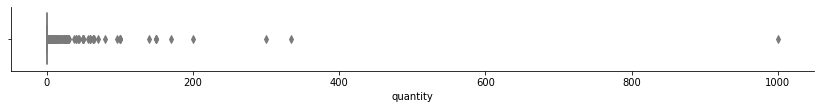

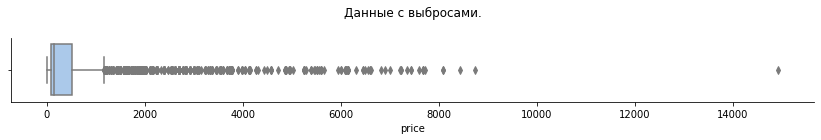

In [45]:
for column in ['quantity', 'price']:    
    g = sns.catplot(x=column, kind="box", 
                    data= df, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(1)
plt.title('Данные с выбросами.'+ "\n")
plt.xlabel(column);

- У нас есть выбросы по количеству закупаемого товара - минимальное количество не больше 1 позиции, максимальное - 1000 позиций в заказе, а среднее значительно выше медианы (2.6 и 1).

- По общей сумме заказов тоже очень большой разброс значений и есть выбросы: средняя сумма стоимости заказа равна 829 рублей, медиана - 194 рублей, минимальная общая сумма заказа - 9 рублей, максимальная - 675 000 тыс рублей.

- У цены также большой разборс значений: минимальная цена за позицию 9 рублей, максимальное - 14 917 рублей, среднее - 530, а медиана, понятно, сильно отличается - 150 рублей.

#### Сначала разберемся с количеством товаров в заказе.

In [46]:
df['quantity'].describe()

count    5547.000000
mean        2.581035
std        16.473007
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

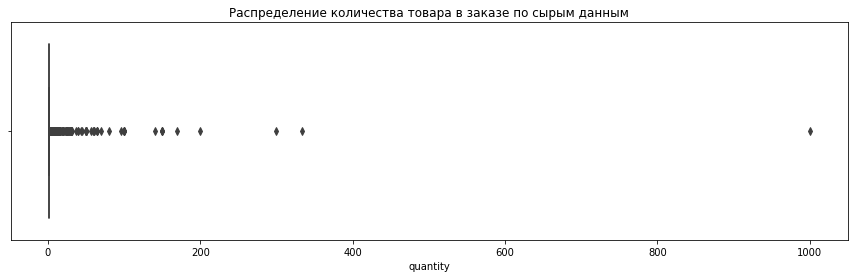

In [47]:
# построим диаграмму размаха по столбцу с количеством товара
plt.figure(figsize=(15,4))
sns.boxplot(x='quantity', data=df) 
plt.title('Распределение количества товара в заказе по сырым данным')
plt.show()

Разброс в количестве купленного товара достаточно большой (стандартное отклонение около 16 шт.), и есть "всплески" (максимум составляет 1 000 шт.). При этом большинство клиентов покупает товар в количестве 1 шт. (первый, второй и третий квартили равны 1). Среднее количество купленного товара отличается от медианного (1 шт.), что связано с "всплесками" ("выбросами"), и составляет около 2-3 шт.

Подавлющееся число заказов всего на 1 товар, однако среднее значение почти равно 2.6 
Судя по всему, выбросы серьёзно искажают данные. Посмотрим на границу по 99 перцентилю распределения.

In [48]:
# сначала посмотрим на новое максимальное значение
max_quantity = df['quantity'].quantile(.99)
round(max_quantity,2)

25.54

In [49]:
# удаляем из датасета аномальные значения 
df = df[(df['quantity'] < max_quantity)]

#### Посмотрим на аномалии и выбросы в цене

In [50]:
df['price'].describe()

count     5491.000000
mean       534.493914
std        977.296911
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

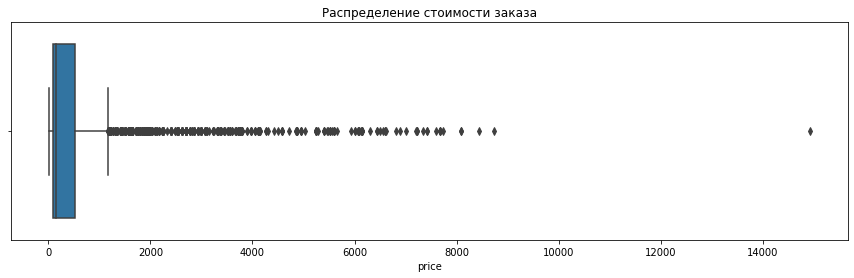

In [51]:
# построим диаграмму размаха по столбцу со стоимостью заказа
plt.figure(figsize=(15,4))
sns.boxplot(x='price', data=df) 
plt.title('Распределение стоимости заказа')
plt.show()

Разброс по ценам товаров для отфильтрованных данных всё ещё достаточно большой (стандартное отклонение около 750), и есть "всплески" (максимум составляет 14 917). При этом большинство клиентов покупает товар в пределах до 500 (минимальная стоимость равна 9 ден.ед., первый квартиль - 90, медиана составляет 150, а третий квартиль - 502). Средняя стоимость единицы купленного товара отличается от медианной, что связано с "всплесками" ("выбросами"), и составляет около 470.

Посмотрим заказ стоимостью 14917

In [52]:
df[(df['price'] == 14917)]

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas,product_category
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,2019-07-01,14917.0,сушилка уличный зелёный,cleaning_washing


In [53]:
df.describe()

,order_id,quantity,price,total_price
count,5491.000000,5491.000000,5491.000000,5491.000000
mean,55723.569295,1.721544,534.493914,654.188748
std,32624.044561,2.537272,977.296911,1202.232643
min,12624.000000,1.000000,9.000000,9.000000
25%,14805.000000,1.000000,90.000000,120.000000
50%,69175.000000,1.000000,150.000000,188.000000
75%,71940.000000,1.000000,524.000000,712.000000
max,112789.000000,25.000000,14917.000000,24370.000000


Все аномалии и выбросы были отброшены из датасета, можно продолжать исследование.

### Количество уникальных покупателей

In [54]:
uniq_clients = len(df['customer_id'].unique())
f"Количество уникальных покупателей: {uniq_clients}"

'Количество уникальных покупателей: 2372'

### Топ-10 самых востребованных товаров

In [55]:
(df['product'].value_counts()
 .head(10)
 .to_frame()
 .reset_index()
 .rename(columns={'index':'product_name', 'product': 'quantity_bought'}))

,product_name,quantity_bought
0,Пеларгония розебудная Red Pandora укорененный черенок,65
1,Пеларгония розебудная Prins Nikolai укорененный черенок,54
2,Пеларгония зональная диам. 12 см сиреневый полумахровый,53
3,Сумка-тележка 2-х колесная Gimi Argo синяя,47
4,Пеларгония розебудная Mary укорененный черенок,40
5,Пеларгония розебудная Queen Ingrid укорененный черенок,31
6,Пеларгония розебудная Margaretha укорененный черенок,31
7,Пеларгония зональная махровая лососевая,25
8,Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок,25
9,Пеларгония зональная диам. 12 см коралловая полумахровая,24


### Динамика продаж по месяцам

In [56]:
grouped_by_month = df.groupby('month').agg({'total_price':'sum'}).reset_index()
grouped_by_month.sort_values(by='total_price', ascending=False)

,month,total_price
0,2018-10-01,323466.000000
1,2018-11-01,305872.000000
2,2018-12-01,295583.000000
4,2019-02-01,295458.000000
6,2019-04-01,294496.000000
5,2019-03-01,241406.000000
9,2019-07-01,226600.000000
7,2019-05-01,207198.000000
14,2019-12-01,202885.333333
12,2019-10-01,193857.000000


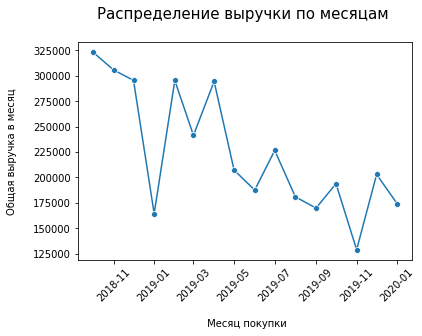

In [57]:
sns.lineplot(data=grouped_by_month, x="month", y="total_price", marker='o')
plt.xticks(rotation=45)
plt.title('Распределение выручки по месяцам \n', fontsize=15)
plt.ylabel('Общая выручка в месяц\n')
plt.xlabel('\n Месяц покупки')
plt.show();

В целом выручка распределяется равномерно, если не считать внезапный и при этом очень высокий рост выручки в июне. По данным описательной статистики есть выбросы и это, похоже, они: слишком высокий пик на фоне всего остального. Дальше мы этот вопрос обязательно исследуем.

### Ассортимент товаров

Посмотрим на распределение количества уникальных товаров в каждой товарной категории в наших транзакциях.

In [58]:
df_product_cat = (df.groupby('product_category')['product'].agg('nunique')
 .reset_index()
 .rename(columns={'index':'product_category', 'product': 'number_of_unique_goods'})
 .sort_values(by='number_of_unique_goods', ascending=False)                 
                 )
df_product_cat['precentage'] = (df_product_cat['number_of_unique_goods']/df['product'].nunique())*100
df_product_cat.style.format({'precentage': '{:.0f}'}).background_gradient(cmap='Blues', axis=0)

,product_category,number_of_unique_goods,precentage
7,plants_seeds,967,42
2,cleaning_washing,370,16
5,kitchen,319,14
3,home_decor,177,8
9,storage,145,6
0,bags_carts,109,5
1,bathroom_wc,101,4
8,renovation,67,3
4,home_linen,61,3
6,no_category,2,0


In [59]:
df['product'].nunique()

2318

### Создание сводной таблицы с профилями покупателей

#### Добавление числовых показателей и даты последнего заказа

Сделаем группировку по покупателям и их заказам и выведем общую сумму для каждого заказа. Нам она понадобится, чтобы вычислить средний чек для каждого покупателя. Мы не можем сразу по каждому order_id вычислять средний чек, потому что у нас может быть несколько строк с одним айди, если в заказе несколько разных позиций.

In [60]:
groupped_by_orders = df.groupby(['customer_id','order_id']).agg({'total_price': 'sum', 'quantity': 'sum'}).reset_index()
groupped_by_orders.head()

,customer_id,order_id,total_price,quantity
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,555.0,4
1,001cee7f-0b29-4716-b202-0042213ab038,70290,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,914.0,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,2324.0,2


На основе этой промежуточной сводной таблицы вычислим средний чек заказов и среднее количество товаров в чеке покупателя.

In [61]:
average_order_price = (groupped_by_orders.
      groupby('customer_id')
      .agg({'total_price': 'mean', 'quantity': 'mean'})
      .rename(columns={'total_price':'average_order_price', 'quantity': 'average_order_size'})
      .reset_index())
average_order_price.head()

,customer_id,average_order_price,average_order_size
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,4.0
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,2.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,2.0


Создадим сводную таблицу по каждому покупателю.

In [62]:
profiles = (df
            .sort_values(by=['customer_id', 'month'])
            .groupby(['customer_id'])
            .agg(
                {
                    'month': 'last',
                    'total_price': 'sum',
                    'order_id': 'nunique',
                    'quantity': 'sum',
    
                }
            )
            .rename(columns={'month': 'last_order','total_price': 'total_order_price', 'order_id':'number_of_orders', 'quantity': 'total_of_goods'})
            .reset_index()
           )

In [63]:
pd.set_option('display.float_format', '{:.2f}'.format)
profiles.head(100)

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-01,555.00,1,4
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-01,442.00,1,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-01,914.00,1,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-01,1649.00,1,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-01,2324.00,1,2
...,...,...,...,...,...
95,09bcc3d0-8134-4f00-8ea5-b74b55d766ad,2019-06-01,5549.00,1,1
96,09fd0763-f767-4572-b986-3ac312ddfd17,2020-01-01,1431.00,2,2
97,0a1aba10-339a-4a3b-b67a-a5de46cc961c,2019-03-01,412.00,1,1
98,0a1b82ed-6fa9-486b-b358-4746f82f6e77,2019-12-01,306.00,2,2


Добавляем в профиль средний чек.

Объединяем профили с `average_order_price`

In [64]:
profiles = profiles.merge(average_order_price, how='left')

Смотрим на наш профиль потребления.

In [65]:
profiles.head()

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-01,555.00,1,4,555.00,4.00
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-01,442.00,1,1,442.00,1.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-01,914.00,1,2,914.00,2.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-01,1649.00,1,1,1649.00,1.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-01,2324.00,1,2,2324.00,2.00


Проверим на каком-нибудь покупателе, что у нас получилось. Покупатель с айди 0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e совершил 3 заказа.

In [66]:
check = df.query('customer_id=="0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e"')
display(check)
print("Дата последнего заказа:", check['date'].max())
print("Общая сумма всех заказов:", check['total_price'].sum())
print("Количество совершенных заказов:", check['order_id'].nunique())
print("Общее количество заказанных товаров:", check['quantity'].sum())
print("Средний чек по всем заказам:", check['total_price'].sum()/3)
print("Среднее количество товаров в заказе:", check['quantity'].sum()/3)

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas,product_category
6145,2019-08-21 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14920,Пеларгония зональная диам. 12 см сиреневый полумахровый,1,188.00,2019-08-01,188.00,пеларгония зональный диам сиреневый полумахровый,plants_seeds
6146,2019-08-21 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14920,Пеларгония розебудная Mary укорененный черенок,1,135.00,2019-08-01,135.00,пеларгония розебудный укоренить черенок,plants_seeds
6147,2019-08-21 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14920,Пеларгония розебудная Prins Nikolai укорененный черенок,2,135.00,2019-08-01,270.00,пеларгония розебудный укоренить черенок,plants_seeds
6148,2019-08-21 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14920,Пеларгония тюльпановидная EMMA,1,135.00,2019-08-01,135.00,пеларгония тюльпановидный,plants_seeds
6200,2019-08-27 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14926,"Флокс метельчатый сорт Чурленис, диаметр горшка 10см.",1,135.00,2019-08-01,135.00,флокс метельчатый сорт чурленис диаметр горшок,plants_seeds
6199,2019-08-27 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14926,"Флокс метельчатый сорт ПОЛИНА, диаметр горшка 10см.",1,135.00,2019-08-01,135.00,флокс метельчатый сорт полина диаметр горшок,plants_seeds
6197,2019-08-27 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14926,"Флокс метельчатый сорт Мари, диаметр горшка 10см.",1,135.00,2019-08-01,135.00,флокс метельчатый сорт марь диаметр горшок,plants_seeds
6196,2019-08-27 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14926,Пеларгония тюльпановидная EMMA,1,135.00,2019-08-01,135.00,пеларгония тюльпановидный,plants_seeds
6198,2019-08-27 05:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14926,"Флокс метельчатый сорт Морской петух Новый сорт, диаметр горшка 10см.",1,135.00,2019-08-01,135.00,флокс метельчатый сорт морской петух новый сорт диаметр горшок,plants_seeds
6542,2019-10-08 13:00:00,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,14940,Пеларгония розебудная Mary укорененный черенок,1,135.00,2019-10-01,135.00,пеларгония розебудный укоренить черенок,plants_seeds


Дата последнего заказа: 2019-10-08 13:00:00
Общая сумма всех заказов: 1538.0
Количество совершенных заказов: 3
Общее количество заказанных товаров: 11
Средний чек по всем заказам: 512.6666666666666
Среднее количество товаров в заказе: 3.6666666666666665


In [67]:
profiles.query('customer_id=="0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e"')

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size
123,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,2019-10-01,1538.00,3,11,512.67,3.67


### Добавление количества заказов в каждой категорий для каждого покупателя

Нам интересно посмотреть для каждого покупателя, товары из каких категорий он заказывает чаще всего.

In [68]:
# Сначала сгруппируем по заказам и покупателям
group_orders = (df.groupby(['customer_id', 'order_id'])
                .agg({'product_category': 'value_counts'})
                .rename(columns={'product_category':'number_of_categories_in_order'})
                .reset_index())

# Теперь на основе этой группировки создадим сводную табличку, 
#где на каждого покупателя по каждой категории будет указано кол-во заказов
custom_order_cat = (group_orders.pivot_table(index=['customer_id'], 
                                             columns='product_category', 
                                             values='order_id', aggfunc='count')
                    .reset_index()
                    .fillna(0))
custom_order_cat.columns.name = None
custom_order_cat

,customer_id,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,no_category,plants_seeds,renovation,storage
0,000d6849-084e-4d9f-ac03-37174eaf60c4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,001cee7f-0b29-4716-b202-0042213ab038,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...
2367,ff601403-b094-4b86-9ac6-264d725b9277,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2368,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2369,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2370,ffb80538-3fda-4351-8ea9-9d2bec58bb07,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


Изменим тип данных у числовых признаков - пусть будет целочисленное int8.

In [69]:
for column_name in custom_order_cat.describe().columns:
    custom_order_cat = custom_order_cat.astype({column_name: 'int8'})

Возьмем покупателя с большим количеством заказов в разных категориях.

In [70]:
profiles.query('number_of_orders == 4')

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size
1757,bea7a833-2074-42db-bc49-4457abd3c930,2019-06-01,4409.00,4,30,1102.25,7.50
2071,e0535076-6270-4df2-8621-cb06264a94fa,2019-05-01,636.00,4,4,159.00,1.00


In [71]:
custom_order_cat.query('customer_id=="498f12a4-6a62-4725-8516-cf5dc9ab8a3a"')

,customer_id,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,no_category,plants_seeds,renovation,storage
673,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,0,0,1,0,2,0,0,0,0,0


In [72]:
df.query('customer_id=="498f12a4-6a62-4725-8516-cf5dc9ab8a3a"')

,date,customer_id,order_id,product,quantity,price,month,total_price,product_lemmas,product_category
2970,2019-04-19 18:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71205,"Наматрацник Natures Бархатный бамбук ББ-Н-1-2 односпальный, 100% хлопок, стеганый 90х200 см, с р...",12,1183.00,2019-04-01,14196.00,наматрацник бархатный бамбук односпальный хлопок стёганый резинка угол белый,home_linen
2971,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,Одеяло Wellness T142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306,10,1568.00,2019-04-01,15680.00,одеяло белый темостёганый чехол полиэстер,home_linen
2972,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71207,"Таз пластмассовый строительный круглый 40 л, 1404062",3,188.00,2019-04-01,564.00,таз пластмассовый строительный круглый,cleaning_washing


Все сходится. Мы провели верные расчеты.

Добавим эту таблицу с фичами в нашу общую таблицу с профилем потребления.

Объединяем профили с custom_order_cat.

In [73]:
profiles = profiles.merge(custom_order_cat, how='left')

In [74]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          2372 non-null   object        
 1   last_order           2372 non-null   datetime64[ns]
 2   total_order_price    2372 non-null   float64       
 3   number_of_orders     2372 non-null   int64         
 4   total_of_goods       2372 non-null   int64         
 5   average_order_price  2372 non-null   float64       
 6   average_order_size   2372 non-null   float64       
 7   bags_carts           2372 non-null   int8          
 8   bathroom_wc          2372 non-null   int8          
 9   cleaning_washing     2372 non-null   int8          
 10  home_decor           2372 non-null   int8          
 11  home_linen           2372 non-null   int8          
 12  kitchen              2372 non-null   int8          
 13  no_category          2372 non-nul

In [75]:
profiles.head()

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,no_category,plants_seeds,renovation,storage
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-01,555.00,1,4,555.00,4.00,0,0,0,0,0,0,0,1,0,0
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-01,442.00,1,1,442.00,1.00,0,0,1,0,0,0,0,0,0,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-01,914.00,1,2,914.00,2.00,0,0,1,0,0,0,0,0,0,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-01,1649.00,1,1,1649.00,1.00,1,0,0,0,0,0,0,0,0,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-01,2324.00,1,2,2324.00,2.00,0,0,0,0,0,0,0,0,0,1


## Исследование профиля потребления

### Дата последнего заказа

Изучим месяц, в который произошел последний заказ.

In [76]:
profiles['last_order'].value_counts()

2020-01-01    269
2019-12-01    246
2019-11-01    217
2019-10-01    166
2019-04-01    161
2018-12-01    140
2019-03-01    135
2019-02-01    135
2018-11-01    127
2018-10-01    123
2019-07-01    120
2019-05-01    119
2019-08-01    111
2019-06-01    106
2019-09-01    103
2019-01-01     94
Name: last_order, dtype: int64

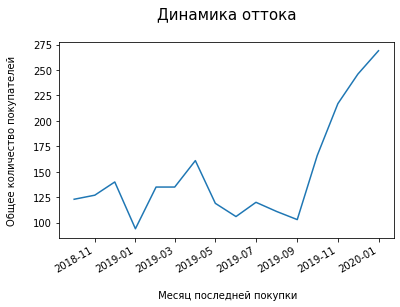

In [77]:
profiles['last_order'].value_counts().plot();
plt.title('Динамика оттока\n', fontsize=15)
plt.xlabel('\n Месяц последней покупки')
plt.ylabel('Общее количество покупателей\n')
plt.show()

In [78]:
("Процент клиентов, которые перестали заказывать после октября и ноября 2018: {:.1%}"
.format((len(profiles[profiles['last_order']=='2020-01-01']) 
         + len(profiles[profiles['last_order']=='2018-11-01']))/uniq_clients)
)

'Процент клиентов, которые перестали заказывать после октября и ноября 2018: 16.7%'

Создадим функцию для исследования нашего профиля потребителей: посмотрим на описательную статистику числовых признаков, построим диаграмму рассеивания.

In [79]:
"""
Функция принимает имя датафрейма и имя столбца датафрейма и 
выводит на экран описательную статистику с помощью функции describe(),
а также рисует точечную диаграмму по признаку-имени столбца.

Аргументы функции:

dataframe - строка (имя датафрейма)
column_name - строка (имя столбца)


Для имени столбца используется словарь вида: ключ словаря - имя столбца, значение - строка-значение признака.

"""
dic_features = {
'total_order_price': '"Общая стоимость всех заказов"',
'number_of_orders': '"Общее количество совершенных заказов"',
'total_of_goods': '"Общее количество купленных товаров"',
'average_order_price': '"Средний чек"',
'average_order_size': '"Среднее количество позиций в заказе"',
'bags_carts': '"Количество заказов в категории "Тележки-сумки""',
'bathroom_wc': '"Количество заказов в категории "Ванная и туалет""',
'cleaning_washing':'"Количество заказов в категории "Уборка""',      
'home_decor':'"Количество заказов в категории "Декор и уют""',         
'home_linen':'"Количество заказов в категории "Домашний текстиль""',           
'kitchen':'"Количество заказов в категории "Кухня""',         
'plants_seeds':'"Количество заказов в категории "Растения и семена""', 
'no_category':'"Количество заказов в категории "Остальное""', 
'renovation':'"Количество заказов в категории "Ремонт""',        
'storage':'"Количество заказов в категории "Хранение""'
 }

def get_analysis(dataframe, column_name):
    print('Описательная статистика для признака {} \n'.format(dic_features[column_name]))
    display(dataframe[column_name].describe())
    x_values = pd.Series(range(0,len(dataframe[column_name])))
    plt.scatter(x_values, dataframe[column_name])
    plt.title('\n Диаграмма рассеивания признака {} \n'.format(dic_features[column_name]), fontsize=15)
    plt.show();
    print('95 и 99-й персентили признака: {}'.format(dic_features[column_name]))
    print(np.percentile(dataframe[column_name], [95, 99]))

### Общая стоимость всех заказов

Описательная статистика для признака "Общая стоимость всех заказов" 



count     2372.00
mean      1514.40
std       3906.00
min         15.00
25%        380.00
50%        824.00
75%       1762.00
max     158292.00
Name: total_order_price, dtype: float64

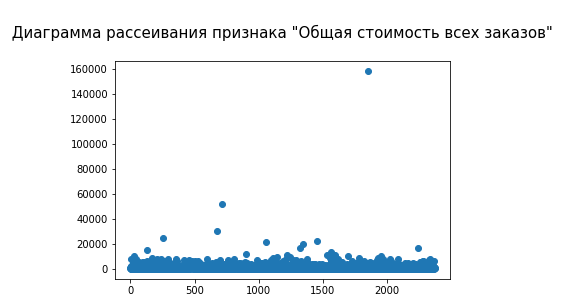

95 и 99-й персентили признака: "Общая стоимость всех заказов"
[4697.3  8699.37]


In [80]:
get_analysis(profiles, 'total_order_price')

### Количество заказов

Описательная статистика для признака "Общее количество совершенных заказов" 



count   2372.00
mean       1.45
std        2.69
min        1.00
25%        1.00
50%        1.00
75%        2.00
max      125.00
Name: number_of_orders, dtype: float64

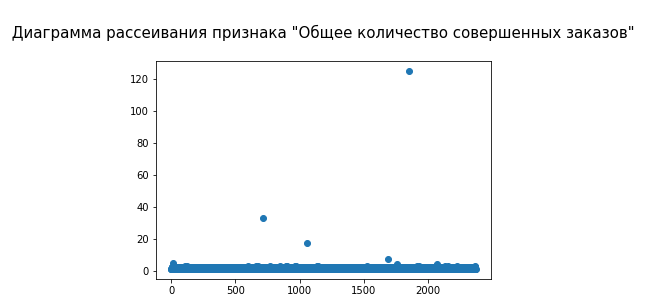

95 и 99-й персентили признака: "Общее количество совершенных заказов"
[2. 3.]


In [81]:
get_analysis(profiles, 'number_of_orders')

На графике хорошо виден тот самый покупатель с 126 заказами (аномальное число заказов для этих данных), у которого общая сумма всех заказов равна 159 508 рублей.

Посмотрим на клиентов, совершивших два и более заказов, посчитаем более точно, какой процент от общего числа клиентов составляют такие покупатели.

За исследуемый период покупатели сделали 1-2 заказа. Покупателей с количеством заказов 3 и более - редкое явление - менее 1%.

In [84]:
profiles.query('number_of_orders >= 2')

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,no_category,plants_seeds,renovation,storage
6,005ba170-45e8-42de-93f7-192481ae2659,2019-11-01,7857.00,2,3,3928.50,1.50,1,1,0,0,0,0,0,0,0,0
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,2019-12-01,321.00,2,2,160.50,1.00,0,0,0,0,0,0,0,2,0,0
10,00cd704a-a65c-4865-b39a-779f1b4f1d1a,2019-12-01,213.00,2,2,106.50,1.00,0,0,0,0,0,1,0,1,0,0
12,00ff5327-0fba-481c-8a07-47a95093a213,2019-12-01,1146.50,2,2,573.25,1.00,0,0,1,0,0,0,0,1,0,0
17,0184f535-b60a-4914-a982-231e3f615206,2019-05-01,5891.00,5,58,1178.20,11.60,0,0,0,0,0,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,fe3e6382-3272-4045-8601-c9acfc08006f,2019-12-01,636.00,2,2,318.00,1.00,0,0,1,0,0,0,0,1,0,0
2363,fef19457-5e7b-4d5d-b031-806041bc251a,2019-11-01,839.00,2,2,419.50,1.00,1,0,0,0,0,0,0,1,0,0
2365,ff31d802-dae6-484d-a3dc-c9723f1cb538,2019-05-01,5998.00,2,2,2999.00,1.00,0,0,0,0,0,0,0,0,2,0
2366,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,2019-03-01,1610.00,3,3,536.67,1.00,1,0,0,0,0,1,0,1,0,0


In [85]:
("Процент клиентов, совершивших два и более заказов: {:.1%}"
 .format(profiles.query('number_of_orders >= 2').shape[0]/profiles.shape[0]))

'Процент клиентов, совершивших два и более заказов: 36.7%'

**Вывод**

65.8% наших клиентов совершают только 1 заказ.

36.2% процентов клиентов оформляли два и более заказов. При этом среди этих клиентов есть выбросы, хотя доля их мала (1%).

Лишь 1% клиентов оформляли больше 3 заказов. Это можно считать выбросом в этих данных.

### Среднее количество позиций в заказе

Описательная статистика для признака "Среднее количество позиций в заказе" 



count   2372.00
mean       3.18
std        5.37
min        1.00
25%        1.00
50%        1.00
75%        2.00
max       60.00
Name: average_order_size, dtype: float64

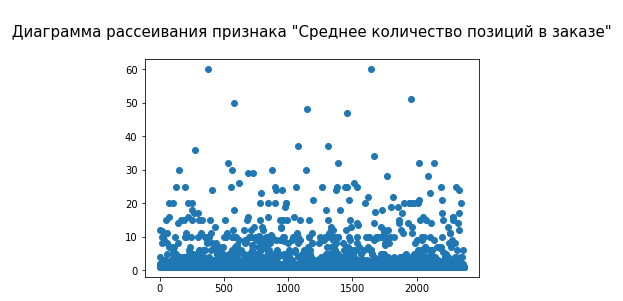

95 и 99-й персентили признака: "Среднее количество позиций в заказе"
[13.225 25.29 ]


In [86]:
get_analysis(profiles, 'average_order_size')

In [87]:
len(profiles.query('average_order_size > 50'))

3

**Вывод**

Половина наших покупателей заказывает в среднем не больше 1 позиции в заказе.

75 % наших покупателей заказывают в среднем не более 3 позиций в заказе.

Лишь 5 процентов покупателей заказывают больше 18 позиций.

Лишь 1 процент покупателей заказывал в среднем больше 50 позиций. Это можно считать выбросом в этих данных.

### Средний чек

Описательная статистика для признака "Средний чек" 



count    2372.00
mean     1076.36
std      1462.38
min        15.00
25%       299.00
50%       636.00
75%      1275.00
max     24370.00
Name: average_order_price, dtype: float64

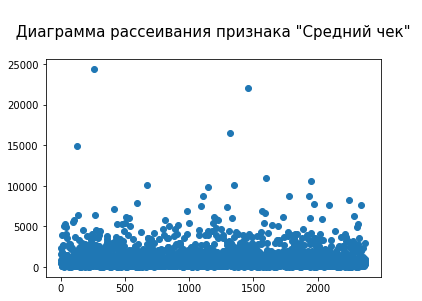

95 и 99-й персентили признака: "Средний чек"
[3570.1 6449. ]


In [88]:
get_analysis(profiles, 'average_order_price')

**Вывод**

У половины наших клиентов средний чек не выше 652 рублей.

У 75% - не выше 1 349 рублей.

Лишь 5 процентов покупателей имеют средний чек выше 3 970 рублей.

Не более 1 процента имеют средний чек выше 7 787 рублей. Это можно считать выбросом в этих данных.

## Фильтрация выбросов в данных

Сделаем срез аномальных пользователей с помощью 99-го персентиля.

Возьмем 99-й персентиль как границу по выбросам.

In [89]:
total_order_price_lim = np.percentile(profiles['total_order_price'], 99)
number_of_orders_lim = np.percentile(profiles['number_of_orders'], 99)
average_order_size_lim = np.percentile(profiles['average_order_size'], 99)
average_order_price_lim = np.percentile(profiles['average_order_price'], 99)
print('Аномальная общая стоимость заказа:', total_order_price_lim)
print('Аномальное число совершенных заказов:', number_of_orders_lim)
print('Аномальное среднее количество позиций в заказе:', average_order_size_lim)
print('Аномальный средний чек', average_order_price_lim)

Аномальная общая стоимость заказа: 8699.369999999999
Аномальное число совершенных заказов: 3.0
Аномальное среднее количество позиций в заказе: 25.289999999999964
Аномальный средний чек 6449.0


Запишем в отдельные переменные наши срезы по клиентам с аномальными значениями признаков.

In [90]:
ab_total_price = profiles.query("total_order_price > @total_order_price_lim")
ab_number_of_orders = profiles.query("number_of_orders > @number_of_orders_lim")
ab_average_order_size = profiles.query("average_order_size > @average_order_size_lim")
ab_average_order_price = profiles.query("average_order_price > @average_order_price_lim")
ab_product_cat = profiles.query("no_category!=0")

Объединим всех наших аномальных клиентов в один фрейм и удалим дубликаты.

In [91]:
abnormal_clients = (
    pd.concat([ab_total_price, ab_number_of_orders,ab_average_order_size, ab_average_order_price,ab_product_cat], axis=0)
    .drop_duplicates()
)
print('\nКоличество аномальных клиентов:', abnormal_clients.shape[0])


Количество аномальных клиентов: 62


In [92]:
abnormal_clients.head()

,customer_id,last_order,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,no_category,plants_seeds,renovation,storage
30,02adb72a-3067-45e9-a3b5-f93d79d7496a,2019-04-01,10723.00,2,2,5361.50,1.00,2,0,0,0,0,0,0,0,0,0
127,0d87f4ae-465a-4fac-81e6-5d629761783e,2019-07-01,14917.00,1,1,14917.00,1.00,0,0,1,0,0,0,0,0,0,0
172,126dac4d-6486-49ed-a1be-9fd55a38a9de,2019-08-01,9148.00,2,2,4574.00,1.00,2,0,0,0,0,0,0,0,0,0
257,1b2764ad-9151-4051-a46a-9b01b62e6335,2018-11-01,24370.00,1,5,24370.00,5.00,0,0,0,0,0,0,0,0,0,1
673,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,2019-04-01,30440.00,3,25,10146.67,8.33,0,0,1,0,2,0,0,0,0,0


Создадим профили наших клиентов без выбросов.

In [93]:
profiles_without_abnormals = profiles[~profiles.index.isin(abnormal_clients.index)]
#Удалим столбец no_category
profiles_without_abnormals = profiles_without_abnormals.drop(['no_category'], axis=1)
print("Размер исходного профиля потребителей:", profiles.shape[0])
print("Размер профиля потребителей без выбросов: ",profiles_without_abnormals.shape[0])

Размер исходного профиля потребителей: 2372
Размер профиля потребителей без выбросов:  2310


Все сходится: 57 клиентов с аномальными значениями удалены из профиля без аномалий.

Посчитаем процент выбросов.

In [94]:
("Процент аномальных клиентов: {:.1%}"
 .format(1 - profiles_without_abnormals.shape[0] / profiles.shape[0]))

'Процент аномальных клиентов: 2.6%'

Теперь мы можем легко анализировать очищенные данные, используя этот датафрейм.

In [95]:
profiles_without_abnormals.describe()

,total_order_price,number_of_orders,total_of_goods,average_order_price,average_order_size,bags_carts,bathroom_wc,cleaning_washing,home_decor,home_linen,kitchen,plants_seeds,renovation,storage
count,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00,2310.00
mean,1262.26,1.38,3.37,954.56,2.82,0.14,0.07,0.29,0.12,0.03,0.18,0.45,0.04,0.09
std,1345.62,0.50,4.44,1008.34,4.07,0.37,0.26,0.51,0.35,0.17,0.41,0.61,0.20,0.31
min,15.00,1.00,1.00,15.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,374.00,1.00,1.00,299.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,797.50,1.00,2.00,600.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1649.00,2.00,3.00,1197.50,2.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
max,8684.00,3.00,35.00,6449.00,25.00,3.00,3.00,2.00,3.00,2.00,3.00,3.00,2.00,2.00


## Распределение покупателей по количеству совершенных заказов в каждой товарной категории.

Построим столбчатые диаграммы по каждой товарной категории (кроме no_category), чтобы увидеть самые популярные и наименее востребованные категории.

Мы будем смотреть на распределение на очищенных от выбросов данных.

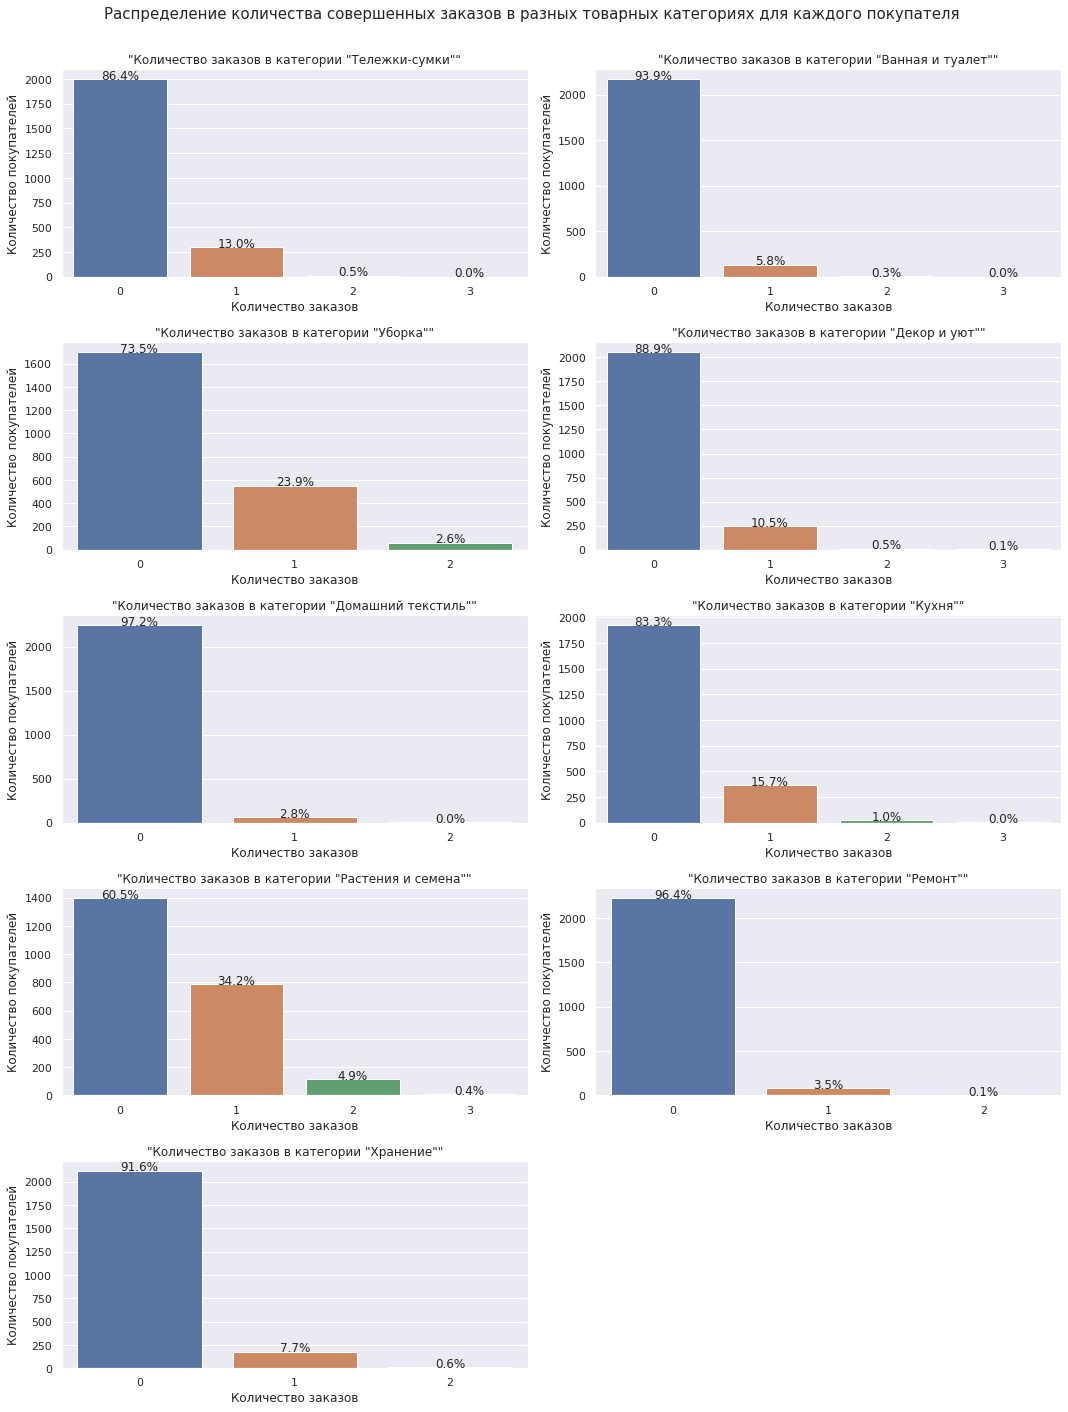

In [96]:
plt.figure(figsize=(15, 20))
sns.set_palette('muted')
sns.set_theme(style="darkgrid")
total = profiles_without_abnormals.shape[0]

for i, col in enumerate((profiles_without_abnormals.drop(['customer_id', 'last_order', 'total_order_price', 
                                       'number_of_orders', 'total_of_goods', 
                                        'average_order_price', 'average_order_size'], axis=1).columns)):
 
    plt.subplot(5, 2,i+1)
    ax = sns.countplot(data=profiles_without_abnormals, x=profiles_without_abnormals[col], order=profiles_without_abnormals[col].value_counts().index)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title(dic_features[col])
    plt.xlabel('Количество заказов')
    plt.ylabel('Количество покупателей')

plt.suptitle('Распределение количества совершенных заказов в разных товарных категориях для каждого покупателя \n\n', fontsize=15)
plt.tight_layout()
plt.show();

**Вывод**

Большая часть наших клиентов приходит за товарами из категории "Растения и семена": 34.3% совершают по 1 заказу, 4.8% делают 2 заказа.

23.5% клиентов сделали по 1 заказу из категории "Уборка", 2.5% клиентов совершили в этой категории 2 заказа.

15.5% клиентов совершили по 1 заказу в категории "Кухня" и 1% клиентов сделали в этой категории 2 заказа.

На третьем месте по популярность среди наших клиентов - категория "Сумки-тележки": 12.9% клиентов совершили 1 заказ, 0.6% сделали 2 заказа.

Меньше всего наших клиентов интересуют категории "Домашний текстиль" и "Ремонт": только 2.8% и 3.5% клиентов совершили 1 заказ соответственно.

## Проверка статистических гипотез

Посмотрим на средние чеки в двух группах: у клиентов, которые перестали заказывать в октябре и ноябре 2018 года (год назад), и у остальных, которые покупали в течение года.

Сформулируем нулевую гипотезу:

𝐻0 - Средний чек у клиентов, переставших покупать год назад, и у тех, кто покупал на протяжении года, равны.

Сформулируем альтерантивную гипотезу:

𝐻1 - Средний чек у клиентов, переставших покупать год назад, и у тех, кто покупал на протяжении года, отличается.

In [97]:
year_ago_group = (profiles_without_abnormals
                  .query('last_order=="2018-10-01" or last_order=="2018-11-01"')
                 )
                  
("Размер выборки клиентов, которые перестали покупать год назад: {}"
 .format(len(year_ago_group))
)

'Размер выборки клиентов, которые перестали покупать год назад: 237'

In [98]:
other_clients = (profiles_without_abnormals[~profiles_without_abnormals
                            .index
                            .isin(profiles_without_abnormals
                                  .query('last_order=="2018-10-01" or last_order=="2018-11-01"')
                                  .index
                                 )]
                )
("Размер выборки клиентов, которые покупали на протяжении года: {}"
 .format(len(other_clients))
)

'Размер выборки клиентов, которые покупали на протяжении года: 2073'

Выборки получились неравномерные по количеству.

Чтобы оценить, какой статистический тест применить в данном случае, проверим, как распределены наши данные с помощью теста Шапиро-Уолка. Ниже создадим функцию для проведения данного теста.

In [99]:
"""Функция для проведения теста Шапиро-Уилка
Критический уровень статистической значимости по умолчанию равен 0.05.
"""

def shapiro_test (sample, alpha = 0.05): 
    results = stats.shapiro(sample)
    p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [100]:
shapiro_test(year_ago_group['average_order_price'])

p-значение:  6.376851120987268e-15
Отвергаем нулевую гипотезу: распределение не нормально


In [101]:
shapiro_test(other_clients['average_order_price'])

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Поскольку у нас данных мало и распределены они ненормально, применим тест Манна-Уитни. Ниже создадим функцию для проведения данного теста.

In [102]:
"""Функция для проведения теста Манна-Уитни
Критический уровень статистической значимости по умолчанию равен 0.05."""

def mannwhitneyu_test(sample1, sample2, alpha = 0.05):   
    results = stats.mannwhitneyu(sample1, sample2)
    print("P-value:{0:.3f}".format(results[1]))
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

In [103]:
mannwhitneyu_test(year_ago_group['average_order_price'], other_clients['average_order_price'])

P-value:0.000
Отвергаем нулевую гипотезу: разница статистически значима.


Проверим средние по нашим выборкам.

In [104]:
("Средний чек в группе клиентов в оттоке: {:.1f}"
 .format(year_ago_group['average_order_price'].mean())
)

'Средний чек в группе клиентов в оттоке: 1252.7'

In [105]:
("Средний чек в группе остальных клиентов: {:.1f}"
 .format(other_clients['average_order_price'].mean())
)

'Средний чек в группе остальных клиентов: 920.5'

Да, действительно отличаются, причем у клиентов в оттоке средний чек выше.

## Общий вывод и рекомендации

Мы проанализировали данные о транзакциях интернет-магазина товаров для дома и быта `"Пока все еще тут"`.

В исходном датасете представлено 7474 строк (каждая строка - запись о заказе) и 6 столбцов-параметров заказа:

    - `date` — дата заказа;
    - `customer_id` — идентификатор покупателя;
    - `order_id` — идентификатор заказа;
    - `product` — наименование товара;
    - `quantity` — количество товара в заказе;
    - `price` — цена товара;


**На этапе предобработки данных мы добавили следующие столбцы:**

    - месяц совершения заказа

    - общая стоимость заказа

**Мы также сегментировали товары по товарным категориям и выделили 9 товарных категорий:**

    1. растения и семена (plants_seeds)
    2. уборка (cleaning_washing)
    3. кухня (kitchen)
    4. тележки-сумки (bags_carts)
    5. ванная и туалет (bathroom_wc)
    6. домашний текстиль (home_linen)
    7. ремонт (renovation)
    8. хранение (storage)
    9. декор и уют (home_decor)

**Самые крупные по количеству приобретенных уникальных товаров товарные категории:**

    - растения и семена (41% от общего количества уникальных товаров в данных)
    - уборка (16% от общего количества уникальных товаров в данных)
    - кухня (14% от общего количества уникальных товаров в данных)
    
**Анализ предобработанных данных показал:**

    - У нас содержатся данные о 2 415 уникальных покупателей.

    - Транзакции были совершены в период с 1 октября 2018 года по 31 января 2020 года.

    - Среди купленных товаров - 3 494 уникальных товара.

    - Самые востребованные товары: разновидности пеларгонии и Сумка-тележка 2-х колесная Gimi Argo синяя.

    - Сезонности в динамике продаж не выявлено: выручка распределена более и менее равномерна.

    - В данных присутствуют выбросы и составляют 57 клиентов.

**На основе данных о транзакциях мы составили сводную таблицу с профилем потребления, где для каждого покупателя представлена информация по следующим признакам:**

    - месяц, когда был совершен последний заказ

    - общая стоимость всех заказов клиента

    - количество совершенных заказов

    - среднее количество позиций в заказе
    
    - средний чек

    - количество совершенных заказов в каждой товарной категории.

**Анализ общего профиля позволяет сделать следующие выводы:**

    - У половины наших клиентов средний чек не выше 652 рублей.

    - У 75% - не выше 1 349 рублей.

    - Лишь 5 процентов покупателей имеют средний чек выше 3 970 рублей.

    - Не более 1 процента имеют средний чек выше 7 787 рублей. Это можно считать выбросом в этих данных.

    - Большая часть наших клиентов приходит за товарами из категории "Растения и семена": 34.3% совершают по 1 заказу, 4.8% делают 2 заказа.

    - 23.5% клиентов сделали по 1 заказу из категории "Уборка", 2.5% клиентов совершили в этой категории 2 заказа.

    - 15.5% клиентов совершили по 1 заказу в категории "Кухня" и 1% клиентов сделали в этой категории 2 заказа.

    - На третьем месте по популярность среди наших клиентов - категория "Сумки-тележки": 12.9% клиентов совершили 1 заказ, 0.6% сделали 2 заказа.

    - Меньше всего наших клиентов интересуют категории "Домашний текстиль" и "Ремонт": только 2.8% и 3.5% клиентов совершили 1 заказ соответственно.
    
    
**Анализ выбросов в данных выявил:**

    - 57 клиентов с аномальной активностью, или 2.3%

**Это клиенты с такими характеристиками:**

    - общая стоимость заказа составляет больше 8823.5 рублей общее число совершенных заказов - больше 3 среднее количество позиций в заказе - больше 50 средний чек - больше 7878.

**Анализ матрицы корреляций признаков показал пары сильно коррелирующих признаков:**

    - общая стоимость всех заказов и средний чек,
    - общее количество всех заказанных товаров и среднее количество позиций в заказе.

**Мы построили дендрограмму на стандартизованных и нормализованных признаках из нашего общего и по результатам у нас получилось 10 кластеров.**

В ходе данного исследования мы укрупнили сегменты клиентов и выделили 5 сегментов c помощью алгоритма машинного обучения КMeans:

    - Два самых крупных кластера - второй и четвертый: 38 % клиентов и 35 % клиентов соответственно. Самый мелкий кластер - первый: всего 0.04% клиентов.

### По итогам данного исследования можно дать следующие рекомендации:

    - Обратить внимание на 14% клиентов, которые ушли в отток в самом начале года. Это клиенты с довольно высоким средним чеком - 1307. Возможно, следует сделать им персонализированные предложения на основе истории их покупок, чтобы вернуть.

    - Прежде всего сделать персонализированные предложения для клиентов первого и третьего кластеров: здесь самый высокий средний чек - 1340 и 1604 рублей соответственно. В пятом кластере разнообразный ассортимент товаров, а в третьем - лидер категория "Сумки-тележки".